In [1]:
# coding=utf-8

%matplotlib inline

import os
import json
import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题！
sns.set_style("darkgrid",{"font.sans-serif":['SimHei','Droid Sans Fallback']})

### 加载user.csv

In [2]:
user_path = '../dataset/orign_data/dataset1/user.csv'
df_user = pd.read_csv(user_path)
df_user.columns = ['rating', 'user_name',
                   'comment_time', 'user_id', 'movie_name', 'genres']
df_user.head()

,rating,user_name,comment_time,user_id,movie_name,genres
0,2,身似,2018-01-05 15:05:06,1,心雨花露,爱情
1,4,有意识的贱民,2018-01-05 15:05:06,3,战争的恐怖,战争
2,2,亿万露电,2018-01-05 15:05:06,4,豪勇七蛟龙,战争
3,2,Marni,2018-01-05 15:05:06,5,无序之主,犯罪
4,4,马西嘻嘻嘻,2018-01-05 15:05:06,6,时装店风波,同性


In [3]:
print(df_user.shape)
print(f'用户数量是:{len(df_user["user_id"].drop_duplicates())}')
print(f'电影数量是:{len(df_user["movie_name"].drop_duplicates())}')

(199813, 6)
用户数量是:13545
电影数量是:23031


In [4]:
df_user['genres'].value_counts()

爱情    39649
犯罪    23318
奇幻    22532
剧情    18588
喜剧    13259
情色    10958
战争     9524
同性     8657
冒险     7847
音乐     7259
传记     6901
恐怖     6142
历史     5287
歌舞     5136
动作     3036
科幻     2706
悬疑     1943
惊悚     1900
武侠     1829
灾难     1727
西部     1615
Name: genres, dtype: int64

### 加载movie.csv

In [5]:
movie_path = '../dataset/orign_data/dataset1/movie.csv'
df_movie = pd.read_csv(movie_path)
df_movie.columns = ['genres', 'actors', 'contries',
                    'director', 'special', 'rating', 'movie_name']
df_movie.head()

,genres,actors,contries,director,special,rating,movie_name
0,剧情,徐峥|王传君|周一围|谭卓|章宇,中国大陆,文牧野,经典,8.9,我不是药神
1,剧情,冯小刚|许晴|张涵予|刘桦|李易峰,中国大陆,管虎,经典,7.8,老炮儿
2,剧情,王宝强|刘昊然|肖央|刘承羽|尚语贤,中国大陆,陈思诚,经典,6.7,唐人街探案2
3,剧情,任素汐|大力|刘帅良|裴魁山|阿如那,中国大陆,周申|刘露,经典,8.3,驴得水
4,剧情,徐峥|王宝强|李曼|李小璐|左小青,中国大陆,叶伟民,经典,7.5,人在囧途


In [6]:
print(f"电影表中电影的数量是:{len(df_movie['movie_name'].drop_duplicates())}")

电影表中电影的数量是:23034


In [7]:
df_movie[df_movie['movie_name']=='心雨花露']

,genres,actors,contries,director,special,rating,movie_name
41273,爱情,姬晨牧,中国大陆,喻瀚湫,青春,6.4,心雨花露
42097,爱情,姬晨牧,中国大陆,喻瀚湫,励志,6.4,心雨花露


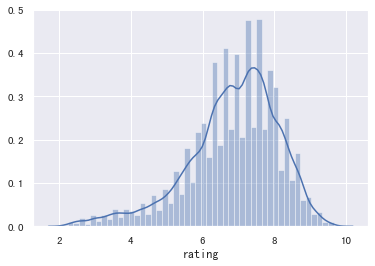

In [8]:
sns.distplot(df_movie['rating'])

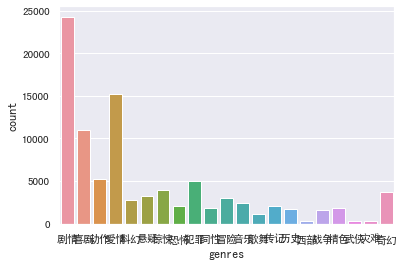

In [9]:
sns.countplot(x='genres',data=df_movie)

### 加载node

In [10]:
node_path = '../dataset/orign_data/dataset2/nodes.csv'
df_node = pd.read_csv(node_path, header=None)
df_node.columns = ['user_id']
df_node.head()

,user_id
0,154907
1,1
2,2
3,3
4,4


### 加载edges

In [11]:
edges_path = '../dataset/orign_data/dataset2/edges.csv'
df_edges = pd.read_csv(edges_path, header=None)
df_edges.columns = ['user_id', 'focus_id']
df_edges.head()

,user_id,focus_id
0,154907,1
1,154907,2
2,154907,3
3,154907,4
4,154907,5


### 处理comment

In [12]:
comment_path = '../dataset/orign_data/DMSC.csv'
df_comment=pd.read_csv(comment_path)
df_comment.columns = ['ID','movie_name_en','movie_name_cn','crawl_date','number','user_name','date','star','comment','like']
df_comment.head()

,ID,movie_name_en,movie_name_cn,crawl_date,number,user_name,date,star,comment,like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045
4,4,Avengers Age of Ultron,复仇者联盟2,2017-01-22,5,ZephyrO,2015-04-22,2,虽然从头打到尾，但是真的很无聊啊。,723


In [13]:
# 只有28部电影的影评，这份数据只能用于用户的特征？？
df_comment['movie_name_cn'].value_counts()

### 处理movie.json

In [14]:
result = []
movie_json_path='../dataset/orign_data/movie.json'
with open(movie_json_path, 'r') as f:
    data_list = f.readlines()
    print(len(data_list))
    for each in data_list:
        each = json.loads(each)
        directors_list = each.get('directors', [])
        first_director = directors_list[0].get('name') if directors_list else None
        directors = '|'.join(map(lambda x: x.get('name'), directors_list))
        genres_list = each.get('genres', [])
        first_genre = genres_list[0] if genres_list else None
        genres = '|'.join(genres_list)
        rating_avg = each.get('rating', {}).get('average')
        rating_people = each.get('rating', {}).get('rating_people')
        stars = each.get('rating', {}).get('stars')
        if isinstance(stars, list) and len(stars) == 5:
            star_5, star_4, star_3, star_2, star_1 = stars
        else:
            star_5, star_4, star_3, star_2, star_1 = [None]*5
        publish_date_list = each.get('pubdate', [])
        publish_date = '|'.join(publish_date_list)
        if publish_date and re.search('(\d{4}-?\d*-?\d*)', publish_date):
            publish_date = re.search(
                '(\d{4}-?\d*-?\d*)', publish_date).group(1)
        year = each.get('year')
        if not re.search('(\d{4})', year):
            year = None
        else:
            year = re.search('(\d{4})', year).group(1)
        contries_list = each.get('countries',[])
        first_contry = contries_list[0] if contries_list else None
        contries = '|'.join(contries_list)
        movie_id = each.get('lens_id')
        actors_list = each.get('casts',[])
        first_actor = actors_list[0].get('name') if actors_list else None
        actors = '|'.join(map(lambda x: x.get('name'), actors_list))
        movie_name = re.search('(\w+)', each.get('title')).group(1)
        summary = each.get('summary')
        languages_list = each.get('languages')
        first_language = languages_list[0] if languages_list else None
        languages = '|'.join(languages_list)
        writers_list = each.get('writers',[])
        first_writer = writers_list[0].get('name') if writers_list else None
        writers = '|'.join(map(lambda x: x.get('name'), writers_list))
        data = {
            'directors': directors,
            'first_director':first_director,
            'genres': genres,
            'fist_genre':first_genre,
            'rating_avg': rating_avg,
            'rating_people': rating_people,
            'star_5': star_5,
            'star_4': star_4,
            'star_3': star_3,
            'star_2': star_2,
            'star_1': star_1,
            'publish_date': publish_date,
            'publish_year': year,
            'contries': contries,
            'first_contry':first_contry,
            'movie_id': movie_id,
            'actors': actors,
            'first_actor':first_actor,
            'movie_name': movie_name,
            'summary': summary,
            'languages': languages,
            'first_language':first_language,
            'writers': writers,
            'first_writer':first_writer
        }
        result.append(data)
df_movie_json = pd.DataFrame(result)
df_movie_json = df_movie_json[['movie_id', 'movie_name', 'genres', 'fist_genre', 'directors', 'first_director', 'actors', 'first_actor',
               'contries', 'first_contry', 'languages','first_language', 'writers', 'first_writer', 'publish_date', 'publish_year',
               'summary', 'rating_people', 'star_5', 'star_4', 'star_3', 'star_2', 'star_1','rating_avg']].sort_values('movie_id')
df_movie_json.head()
df_movie_json.to_csv('../dataset/cleaned_data/movie.csv',index=False)

15752


In [15]:
# 注意 这里是为了保证能够同时关联上user和item选择innerjoin，有数据损失，大家可以在考虑下怎么处理方便，总是感觉数据怪怪的
df_width = pd.merge(df_user[['user_id', 'user_name', 'movie_name',
                             'comment_time', 'rating']], df_movie_json, on='movie_name')
print(df_width.shape)
df_width.head()

(73173, 28)


,user_id,user_name,movie_name,comment_time,rating,movie_id,genres,fist_genre,directors,first_director,...,publish_date,publish_year,summary,rating_people,star_5,star_4,star_3,star_2,star_1,rating_avg
0,4,亿万露电,豪勇七蛟龙,2018-01-05 15:05:06,2,4327,动作|西部,动作,约翰·斯特奇斯,约翰·斯特奇斯,...,1960-10-23,1960,一群强盗每年都要骚扰墨西哥的一个小村庄。村里的长者派三名农夫去美国，目的是寻找武艺高强的枪手...,2221,14.3,48.3,32.7,4.0,0.6,7.4
1,4,亿万露电,豪勇七蛟龙,2018-01-05 15:05:06,2,162350,动作|西部|冒险,动作,安东尼·福奎阿,安东尼·福奎阿,...,2016-09-08,2016,《豪勇七蛟龙/七侠荡寇志》灵感来自黑泽明（AkiraKurosawa）著名的《七武士》（Se...,15611,14.6,45.7,35.5,3.6,0.6,7.4
2,1582,张小北,豪勇七蛟龙,2018-01-05 15:19:13,10,4327,动作|西部,动作,约翰·斯特奇斯,约翰·斯特奇斯,...,1960-10-23,1960,一群强盗每年都要骚扰墨西哥的一个小村庄。村里的长者派三名农夫去美国，目的是寻找武艺高强的枪手...,2221,14.3,48.3,32.7,4.0,0.6,7.4
3,1582,张小北,豪勇七蛟龙,2018-01-05 15:19:13,10,162350,动作|西部|冒险,动作,安东尼·福奎阿,安东尼·福奎阿,...,2016-09-08,2016,《豪勇七蛟龙/七侠荡寇志》灵感来自黑泽明（AkiraKurosawa）著名的《七武士》（Se...,15611,14.6,45.7,35.5,3.6,0.6,7.4
4,15005,小茉莉,豪勇七蛟龙,2018-01-18 17:31:54,10,4327,动作|西部,动作,约翰·斯特奇斯,约翰·斯特奇斯,...,1960-10-23,1960,一群强盗每年都要骚扰墨西哥的一个小村庄。村里的长者派三名农夫去美国，目的是寻找武艺高强的枪手...,2221,14.3,48.3,32.7,4.0,0.6,7.4


In [16]:
df_width = df_width[['user_id', 'user_name', 'movie_id', 'movie_name', 'comment_time', 'rating',
                     'genres', 'fist_genre', 'directors', 'first_director',
                     'actors', 'first_actor', 'contries', 'first_contry', 'languages',
                     'first_language', 'writers', 'first_writer', 'publish_date',
                     'publish_year', 'summary', 'rating_people', 'star_5', 'star_4',
                     'star_3', 'star_2', 'star_1', 'rating_avg']]
df_width.head()

,user_id,user_name,movie_id,movie_name,comment_time,rating,genres,fist_genre,directors,first_director,...,publish_date,publish_year,summary,rating_people,star_5,star_4,star_3,star_2,star_1,rating_avg
0,4,亿万露电,4327,豪勇七蛟龙,2018-01-05 15:05:06,2,动作|西部,动作,约翰·斯特奇斯,约翰·斯特奇斯,...,1960-10-23,1960,一群强盗每年都要骚扰墨西哥的一个小村庄。村里的长者派三名农夫去美国，目的是寻找武艺高强的枪手...,2221,14.3,48.3,32.7,4.0,0.6,7.4
1,4,亿万露电,162350,豪勇七蛟龙,2018-01-05 15:05:06,2,动作|西部|冒险,动作,安东尼·福奎阿,安东尼·福奎阿,...,2016-09-08,2016,《豪勇七蛟龙/七侠荡寇志》灵感来自黑泽明（AkiraKurosawa）著名的《七武士》（Se...,15611,14.6,45.7,35.5,3.6,0.6,7.4
2,1582,张小北,4327,豪勇七蛟龙,2018-01-05 15:19:13,10,动作|西部,动作,约翰·斯特奇斯,约翰·斯特奇斯,...,1960-10-23,1960,一群强盗每年都要骚扰墨西哥的一个小村庄。村里的长者派三名农夫去美国，目的是寻找武艺高强的枪手...,2221,14.3,48.3,32.7,4.0,0.6,7.4
3,1582,张小北,162350,豪勇七蛟龙,2018-01-05 15:19:13,10,动作|西部|冒险,动作,安东尼·福奎阿,安东尼·福奎阿,...,2016-09-08,2016,《豪勇七蛟龙/七侠荡寇志》灵感来自黑泽明（AkiraKurosawa）著名的《七武士》（Se...,15611,14.6,45.7,35.5,3.6,0.6,7.4
4,15005,小茉莉,4327,豪勇七蛟龙,2018-01-18 17:31:54,10,动作|西部,动作,约翰·斯特奇斯,约翰·斯特奇斯,...,1960-10-23,1960,一群强盗每年都要骚扰墨西哥的一个小村庄。村里的长者派三名农夫去美国，目的是寻找武艺高强的枪手...,2221,14.3,48.3,32.7,4.0,0.6,7.4


In [17]:
print(df_width.shape)

(73173, 28)


In [18]:
df_width.to_csv('../dataset/cleaned_data/user.csv',index=False)

In [19]:
df_rating = df_width[['user_id','movie_id','comment_time','rating']]
df_rating.head()

,user_id,movie_id,comment_time,rating
0,4,4327,2018-01-05 15:05:06,2
1,4,162350,2018-01-05 15:05:06,2
2,1582,4327,2018-01-05 15:19:13,10
3,1582,162350,2018-01-05 15:19:13,10
4,15005,4327,2018-01-18 17:31:54,10


In [20]:
df_rating.to_csv('../dataset/cleaned_data/rating.csv',
                 index=False, header=None)

In [21]:
print(f'用户数量是:{len(df_width["user_id"].drop_duplicates())}')
print(f'电影数量是:{len(df_width["movie_name"].drop_duplicates())}')

用户数量是:12935
电影数量是:7653
